### Model Ivar using sky

In [44]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
from scipy.stats import binned_statistic
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes
from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.modeling import models, fitting
output_notebook()
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV

sys.path.append("../")
from importlib import reload
import stack_spectra
reload(stack_spectra)

Loading BokehJS ...

<module 'stack_spectra' from '../stack_spectra.py'>

In [4]:
my_path = Path("/global/cscratch1/sd/bid13/stack_spectra")

In [5]:
data = np.load(my_path / "ELG_1.3_1.4_v0.npz")

In [7]:
flux = data["flux"]
ivar = data["ivar"]
wave = data["wave"]
z_table = data["z_table"]

sky_ivar = data["sky_ivar"]

In [22]:
sky_mask = np.any(np.isfinite(1/sky_ivar), axis=-1)

<ipython-input-22-920d6f407709>:1: RuntimeWarning: divide by zero encountered in true_divide
  sky_mask = np.any(np.isfinite(1/sky_ivar), axis=-1)


In [23]:
flux = flux[sky_mask]
ivar = ivar[sky_mask]
z_table = z_table[sky_mask]

sky_ivar = sky_ivar[sky_mask]

In [ ]:
ivar_model = stack_spectra.model_ivar(ivar, sky_ivar, wave)

In [25]:
flux, ivar, wave = stack_spectra._common_grid(flux, wave, ivar_model, z_table["Z"])

../spectral_resampling.py:236: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(1 / ivar)


In [26]:
flux, ivar = stack_spectra._normalize(flux, ivar)

In [35]:
avg = np.nansum(flux*ivar, axis=0)/np.nansum(ivar, axis=0)

<ipython-input-35-7fdbfd4c88e5>:1: RuntimeWarning: invalid value encountered in true_divide
  avg = np.nansum(flux*ivar, axis=0)/np.nansum(ivar, axis=0)


In [37]:
p = figure(title="Spectra", x_axis_label='Wavelength', y_axis_label='Flux', plot_width=1000, plot_height=300, tooltips=[("Wavelength", "$x"), ("Flux", "$y")]
#            y_range=(-1, 3)
          )
p.line(wave, avg, legend_label="Temp.", line_width=2)

show(p)

In [144]:
# mgII_mask1 = (wave>2792.5) & (wave<2796.5)
mgII_mask1 = (wave>2800) & (wave<2804.5)

In [145]:
x= wave[mgII_mask1]
y = avg[mgII_mask1]

peak: 2801.811423205883


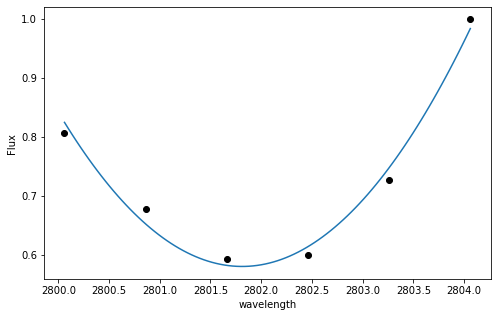

In [146]:
line = models.Polynomial1D(2)
# fit_g = fitting.LevMarLSQFitter()
# fit_g = fitting.SLSQPLSQFitter()
fit_g = fitting.LinearLSQFitter()
g = fit_g(line, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
x_p = np.linspace(x.min(), x.max(),100)
plt.plot(x_p, g(x_p))
plt.xlabel('wavelength')
plt.ylabel('Flux')
print(f"peak: {-1*g.c1/(2*g.c2)}")

In [90]:
# line1 = models.Gaussian1D(amplitude=-1, mean=2795.53, stddev=1.)
# line2 = models.Gaussian1D(amplitude=-1., mean=2802.71, stddev=1.)

line1 = models.Lorentz1D(amplitude=-1, x_0=2795.53, fwhm=1.)
# line2 = models.Lorentz1D(amplitude=-1., x_0=2802.71, fwhm=1.)

# line1 = models.RickerWavelet1D(amplitude=-1, x_0=2795.53, sigma=1.)
line2 = models.RickerWavelet1D(amplitude=-1., x_0=2802.71, sigma=1.)

const = models.Const1D(amplitude=1)
fit_g = fitting.LevMarLSQFitter()
# fit_g = fitting.SLSQPLSQFitter()
g = fit_g(line1+line2+const, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
x_p = np.linspace(x.min(), x.max(),100)
plt.plot(x_p, g(x_p))
plt.xlabel('wavelength')
plt.ylabel('Flux')

TypeError: Improper input: N=7 must not exceed M=5

In [53]:
g.amplitude_2

Parameter('amplitude', value=1.042638817822305)